In [1]:
from preprocessing.data_lstm import read_data_for_speaker
from lstm_utils.callbacks import Statistics
import matplotlib.pyplot as plt
import os
import numpy as np

import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.recurrent import GRU
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding3D
from keras.layers.core import Lambda, Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam, Adadelta, SGD
from keras import backend as K

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
CURRENT_PATH = '/home/ubuntu/assignments/machine-lip-reading'
DATA_PATH = CURRENT_PATH + '/data'

def ctc_lambda_func(args):
    import tensorflow as tf
    y_pred, labels, input_length, label_length = args
    # From Keras example image_ocr.py:
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :]
    label_length = K.cast(tf.squeeze(label_length),'int32')
    input_length = K.cast(tf.squeeze(input_length),'int32')
    labels = K.ctc_label_dense_to_sparse(labels, label_length)
    #y_pred = y_pred[:, :, :]
    #return K.ctc_batch_cost(labels, y_pred, input_length, label_length, ignore_longer_outputs_than_inputs=True)
    return tf.nn.ctc_loss(labels, y_pred, input_length, ctc_merge_repeated=False,
                         ignore_longer_outputs_than_inputs = True, time_major = False)
def CTC(name, args):
	return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)


def build_model(input_size, output_size = 28, max_string_len = 10):
    # model = Sequential()
    input_data = Input(name='the_input', shape=input_size, dtype='float32')
    x = ZeroPadding3D(padding=(0,2,2), name='padding1')(input_data)
    x = TimeDistributed(Conv2D(filters=96, kernel_size = 5, strides = (2,2),
                             padding='same', activation = 'relu'))(x)

    #x = TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, name='max1'))(x)
    #x = Dropout(0.5)(x)

    x = TimeDistributed(Conv2D(filters=96, kernel_size=5, strides=(2, 2),
                               padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, name='max1'))(x)
    x = Dropout(0.5)(x)

    x = TimeDistributed(Conv2D(filters=4, kernel_size=5, strides=(2, 2),
                               padding='same', activation='relu'))(x)
    #x = TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, name='max1'))(x)
    #x = Dropout(0.5)(x)

    input_lstm = TimeDistributed(Flatten())(x)

    x_lstm = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat')(input_lstm)
    x_lstm = Dense(output_size, kernel_initializer='he_normal', name='dense1')(x_lstm)
    print("after dense1")
    y_pred = Activation('softmax', name='softmax')(x_lstm)

    labels = Input(name='the_labels', shape = [max_string_len], dtype='int32')
    input_length = Input(name = 'input_length', shape =[1], dtype = 'int32')
    label_length = Input(name = 'label_length', shape = [1], dtype = 'int32')
    loss = CTC('ctc', [y_pred, labels, input_length, label_length])
    model = Model(inputs=[input_data, labels, label_length, input_length],
                  outputs = loss)
    model.summary()
    # Build model here...

    return model
def pad_labels(labels, max_string_len):
    padding = np.ones((labels.shape[0], max_string_len - labels.shape[1])) * -1
    return np.concatenate((labels, padding), axis = 1)

def train(model, x_train, y_train, label_len_train, input_len_train, batch_size=256, epochs=100, val_train_ratio=0.2):
    max_string_len = 10
    if y_train.shape[1] != max_string_len:
        y_train = pad_labels(y_train, max_string_len)

    adadelta = Adadelta(lr=0.001, decay=0.001)
    adam = Adam(lr=.00011)
    sgd = SGD(lr=0.0005)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

    stats = Statistics(model, x_train, y_train, input_len_train,
                        label_len_train, num_samples_stats=256, output_dir='lstm_model/results')
    history = model.fit(x = {'the_input':x_train, 'the_labels':y_train, 'label_length':label_len_train,
                             'input_length':input_len_train}, y = {'ctc': np.zeros([x_train.shape[0]])},
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_train_ratio,
                        callbacks = [stats],
                        shuffle=True,
                        verbose=1)

    return history

def pad_input(x, max_str_len):
    # pad on axis = 1
    padding = np.zeros((x.shape[0], max_str_len - x.shape[1], x.shape[2], x.shape[3], x.shape[4]))
    return np.concatenate((x,padding),axis = 1)

In [3]:
epochs = 10
max_str_len = 25
x_s = np.ndarray(shape=(0, max_str_len, 50, 100, 3))
y_s = np.ndarray(shape=(0, 6))
label_lens = np.array([])
input_lens = np.array([])
    
start = time.time()
for count in range(1, 2):
        
    print("loading data for ", count)
    x, y, label_len, input_len = read_data_for_speaker("s1", count)
    x = pad_input(x, max_str_len)
    x_s = np.vstack((x, x_s))
    y_s = np.vstack((y, y_s))
    label_lens = np.concatenate([label_len, label_lens])
    input_lens = np.concatenate([input_len, input_lens])
    
end = time.time()
print("load data took", end-start)

print(x_s.shape, y_s.shape)
x_train, x_test, y_train, y_test, label_len_train, label_len_test, \
input_len_train, input_len_test = train_test_split(x_s, y_s, label_lens, input_lens, test_size=0.2)
model2 = build_model(x.shape[1:], 28, max_string_len=10)
history2 = train(model2, x_train, y_train, label_len_train, input_len_train, epochs=epochs)
 
print("Finish Training")
model2.save('model_lstm6.h5')

('loading data for ', 1)
('load data took', 10.089028120040894)
((1000, 25, 50, 100, 3), (1000, 6))
after dense1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 25, 50, 100,  0                                            
__________________________________________________________________________________________________
padding1 (ZeroPadding3D)        (None, 25, 54, 104,  0           the_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 25, 27, 52, 9 7296        padding1[0][0]                   
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 25, 14, 26, 9 230496      time_distributed_1[0][0]      

Plotting...
Done.


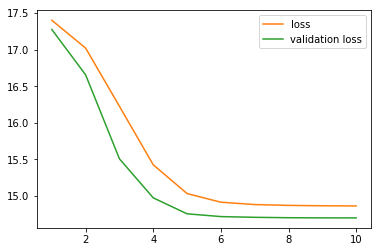

In [4]:
history2.history
print("Plotting...")
# f, (ax1, ax2) = plt.subplots(2, 1)
# ax1.plot(range(1, epochs + 1), history2.history['val_acc'], 'tab:blue', label="validation accuracy")
# ax1.plot(range(1, epochs + 1), history2.history['acc'], 'tab:red', label="training accuracy")
plt.plot(range(1, epochs + 1), history2.history['loss'], 'tab:orange', label="loss")
plt.plot(range(1, epochs + 1), history2.history['val_loss'], 'tab:green', label="validation loss")

# ax1.legend()
plt.legend()

plt.savefig('submit2.png', dpi=300)
print("Done.")

In [6]:
epochs = 10
max_str_len = 25
x_s = np.ndarray(shape=(0, max_str_len, 50, 100, 3))
y_s = np.ndarray(shape=(0, 6))
label_lens = np.array([])
input_lens = np.array([])
    
start = time.time()
for count in range(1, 7):
        
    print("loading data for ", count)
    x, y, label_len, input_len = read_data_for_speaker("s1", count)
    x = pad_input(x, max_str_len)
    x_s = np.vstack((x, x_s))
    y_s = np.vstack((y, y_s))
    label_lens = np.concatenate([label_len, label_lens])
    input_lens = np.concatenate([input_len, input_lens])
    
end = time.time()
print("load data took", end-start)

print(x_s.shape, y_s.shape)
x_train, x_test, y_train, y_test, label_len_train, label_len_test, \
input_len_train, input_len_test = train_test_split(x_s, y_s, label_lens, input_lens, test_size=0.2)
model2 = build_model(x.shape[1:], 28, max_string_len=10)
history2 = train(model2, x_train, y_train, label_len_train, input_len_train, epochs=epochs)
 
print("Finish Training")
model2.save('model_lstm_filter96.h5')





('loading data for ', 1)
('loading data for ', 2)
('loading data for ', 3)
('loading data for ', 4)
('loading data for ', 5)
('loading data for ', 6)
('load data took', 76.89570999145508)
((5934, 25, 50, 100, 3), (5934, 6))
after dense1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 25, 50, 100,  0                                            
__________________________________________________________________________________________________
padding1 (ZeroPadding3D)        (None, 25, 54, 104,  0           the_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 25, 27, 52, 9 7296        padding1[0][0]                   
______________________________________________________________________

NameError: name 'history' is not defined

Plotting...
Done.


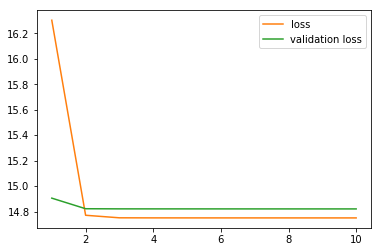

In [7]:
print("Plotting...")

plt.plot(range(1, epochs + 1), history2.history['loss'], 'tab:orange', label="loss")
plt.plot(range(1, epochs + 1), history2.history['val_loss'], 'tab:green', label="validation loss")

plt.legend()

plt.savefig('training_lstm2.png', dpi=300)
print("Done.")

In [14]:
start = time.time()
print("loading data")
x, y, label_len, input_len = read_data_for_speaker("s1", 1)
end = time.time()
print("load data took", end-start)
print("training data shapes:", x.shape, y.shape)
x = pad_input(x, 20)
x_train, x_test, y_train, y_test, label_len_train, label_len_test, \
input_len_train, input_len_test = train_test_split(x, y, label_len, input_len, test_size=0.2)
model = build_model(x.shape[1:], 28, max_string_len=10)
history = train(model, x_train, y_train, label_len_train, input_len_train, epochs=10)

print("Finish Training for ")
model.save('modeltest.h5')

loading data
('load data took', 8.022416114807129)
('training data shapes:', (1000, 19, 50, 100, 3), (1000, 6))
after dense1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 20, 50, 100,  0                                            
__________________________________________________________________________________________________
padding1 (ZeroPadding3D)        (None, 20, 54, 104,  0           the_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_31 (TimeDistri (None, 20, 27, 52, 3 2432        padding1[0][0]                   
__________________________________________________________________________________________________
time_distributed_32 (TimeDistri (None, 20, 14, 26, 3 25632       time_distributed_3

Plotting...
Done.


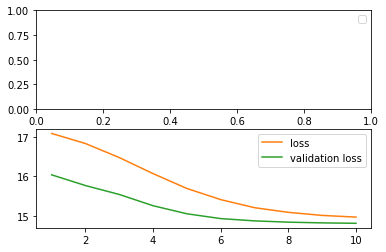

In [4]:
import pickle
from keras.models import Sequential

# ['acc', 'loss', 'val_acc', 'val_loss'][
epochs = 10
print("Plotting...")
f, (ax1, ax2) = plt.subplots(2, 1)
# ax1.plot(range(1, epochs+1), history.history['val_acc'], 'tab:blue', label="validation accuracy")
# ax1.plot(range(1, epochs+1), history.history['acc'], 'tab:red', label="training accuracy")

ax2.plot(range(1, epochs+1), history.history['loss'], 'tab:orange', label="loss")
ax2.plot(range(1, epochs+1), history.history['val_loss'], 'tab:green', label="validation loss")

ax1.legend()
ax2.legend()

f.savefig('training1.png', dpi=300)
print("Done.")


In [27]:
print(history.history)

{'loss': [17.288757705688475, 17.071856689453124, 16.646013450622558, 16.022693634033203, 15.394560432434082, 14.994970321655273, 14.823009872436524, 14.758896446228027, 14.737957000732422, 14.728717613220216], 'val_loss': [16.918800354003906, 16.536846160888672, 15.735244750976562, 15.355722427368164, 14.766497611999512, 14.57081413269043, 14.531534194946289, 14.518696784973145, 14.514190673828125, 14.511941909790039]}


In [4]:
epochs = 50
max_str_len = 25
x_s = np.ndarray(shape=(0, max_str_len, 50, 100, 3))
y_s = np.ndarray(shape=(0, 6))
label_lens = np.array([])
input_lens = np.array([])
    
start = time.time()
for count in range(1, 7):
        
    print("loading data for ", count)
    x, y, label_len, input_len = read_data_for_speaker("s1", count)
    x = pad_input(x, max_str_len)
#     print(x.shape, y.shape, label_len.shape, input_len.shape)
#     print(x_s.shape, y_s.shape, len(label_lens), len(input_lens))
    x_s = np.vstack((x, x_s))
    y_s = np.vstack((y, y_s))
    label_lens = np.concatenate([label_len, label_lens])
    input_lens = np.concatenate([input_len, input_lens])
    
end = time.time()
print("load data took", end-start)

print(x_s.shape, y_s.shape)
x_train, x_test, y_train, y_test, label_len_train, label_len_test, \
input_len_train, input_len_test = train_test_split(x_s, y_s, label_lens, input_lens, test_size=0.2)
model = build_model(x.shape[1:], 28, max_string_len=10)
history = train(model, x_train, y_train, label_len_train, input_len_train, epochs=epochs)
 
print("Finish Training")

model.save('model_lstm4.h5')

('loading data for ', 1)
('loading data for ', 2)
('loading data for ', 3)
('loading data for ', 4)
('loading data for ', 5)
('loading data for ', 6)
('load data took', 76.4719808101654)
((5934, 25, 50, 100, 3), (5934, 6))
after dense1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 25, 50, 100,  0                                            
__________________________________________________________________________________________________
padding1 (ZeroPadding3D)        (None, 25, 54, 104,  0           the_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 25, 27, 52, 3 2432        padding1[0][0]                   
_______________________________________________________________________



[Epoch 25] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 27/50
3797/3797 [==============================] - 331s 87ms/step - loss: 14.8315 - val_loss: 14.8787


[Epoch 26] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 28/50
3797/3797 [==============================] - 331s 87ms/step - loss: 14.8307 - val_loss: 14.8786


[Epoch 27] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 29/50
3797/3797 [==============================] - 330s 87ms/step - loss: 14.8301 - val_loss: 14.8784


[Epoch 28] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 30/50
3797/3797 [==============================] - 331s 87ms/step - loss: 14.8295 - val_loss: 14.8783


[Epoch 29] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 31/50
3797/3797 [==============================] - 331s 87ms/step - loss: 14.8291 - val_loss: 14.8782


[Epoch 30] Out of 256 samples: [CER: 3.293 - 1.000] 

Epoch 32/50
 512/3797 [===>..........................] - ETA: 4:17 - loss: 14.8116

KeyboardInterrupt: 

Plotting...


NameError: name 'history' is not defined

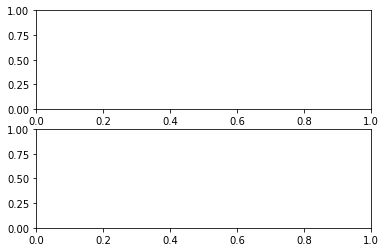

In [5]:
epochs = 10
print("Plotting...")
f, (ax1, ax2) = plt.subplots(2, 1)
# ax1.plot(range(1, epochs+1), history.history['val_acc'], 'tab:blue', label="validation accuracy")
# ax1.plot(range(1, epochs+1), history.history['acc'], 'tab:red', label="training accuracy")

ax2.plot(range(1, epochs+1), history.history['loss'], 'tab:orange', label="loss")
ax2.plot(range(1, epochs+1), history.history['val_loss'], 'tab:green', label="validation loss")

ax1.legend()
ax2.legend()

f.savefig('training3.png', dpi=300)
print("Done.")

array([4.9e-324, 9.9e-324, 1.5e-323, 2.0e-323, 2.5e-323, 3.0e-323,
       3.5e-323, 4.0e-323, 4.4e-323, 4.9e-323])

array([1., 2., 3., 4., 5.])